In [151]:
import torch
import torchvision
from torchvision import models, transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
device =  torch.device('cuda')

In [222]:
class_name = {
    0: 'down',
    1: 'middle',
    2: 'up'
}

In [167]:
vgg16 = models.vgg16(pretrained=True).to(device)
print(vgg16.modules)

<bound method Module.modules of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2,

In [168]:
for param in vgg16.parameters():
    param.requires_grad = False
vgg16.classifier._modules['6'] = nn.Linear(4096, 3)

In [169]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.0001, momentum=0.9)

Copy data from Google Bucket

In [ ]:
import csv
import subprocess

with open('/home/jupyter/Pushup-Auto-Counter-CV/pushup_data.csv', newline='') as pushup_data:
    reader = csv.reader(pushup_data, delimiter=' ', quotechar='|')
    for row in reader:
        
        row = row[0].split(',')
        
        image_path = row[1]
        
        folder = 'train' if row[0] == 'TRAIN' else 'test' if row[0] == 'TEST' else 'validation'
        label = row[2]
        
        bashCommand = f'sudo gsutil cp {image_path} /home/jupyter/Pushup-Auto-Counter-CV/data/{folder}/{label}'
        
        process = subprocess.Popen(bashCommand.split(), stdout=subprocess.PIPE)
        output, error = process.communicate()

print('Data downloaded')


In [238]:
transform = transforms.Compose([
    transforms.Resize((180, 320)),  
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


trainset = torchvision.datasets.ImageFolder(root='/home/jupyter/Pushup-Auto-Counter-CV/data/train', transform=transform)
valset = torchvision.datasets.ImageFolder(root='/home/jupyter/Pushup-Auto-Counter-CV/data/validation', transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=8,
                                          shuffle=True)

valloader = torch.utils.data.DataLoader(valset, batch_size=8,
                                          shuffle=True)


In [170]:
epochs = 10
vgg16.cuda()
running_loss = 0
for j in range(epochs):
    for i, data in enumerate(trainloader):
        vgg16.train()
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = vgg16(inputs) # Forward Propogation
        loss = criterion(outputs, labels) # get loss from loss fn
        loss.backward()
        optimizer.step()

        running_loss += loss.item() # Update batch loss to later average
        if i % 5 == 4:    # print every 2000 mini-batches
            # Outpul validation loss
            print('[%d, %5d] Loss: %.3f' %
                (j + 1, i + 1, running_loss / 100))
            running_loss = 0
    # print('Accuracy at end of epoch %d: %.3f' % (
    #     epoch, get_accuracy(vgg16, dataloader)))


[1,     5] Loss: 0.055
[1,    10] Loss: 0.058
[2,     5] Loss: 0.089
[2,    10] Loss: 0.054
[3,     5] Loss: 0.088
[3,    10] Loss: 0.050
[4,     5] Loss: 0.080
[4,    10] Loss: 0.047
[5,     5] Loss: 0.076
[5,    10] Loss: 0.045
[6,     5] Loss: 0.069
[6,    10] Loss: 0.041
[7,     5] Loss: 0.069
[7,    10] Loss: 0.040
[8,     5] Loss: 0.062
[8,    10] Loss: 0.038
[9,     5] Loss: 0.062
[9,    10] Loss: 0.037
[10,     5] Loss: 0.057
[10,    10] Loss: 0.037


In [171]:
correct = 0
total = 0
vgg16.cuda()
with torch.no_grad():           # Do not update gradients when evaluating
    for data in valloader: 
        images, labels = data[0].to(device), data[1].to(device) #Put data on CUDA
        vgg16.eval() # Set model to eval mode
        outputs = vgg16(images) # Run forward prop
        _, predicted = torch.max(outputs.data, 1) # Get the arg max
        total += labels.size(0) # Add the mini batch size
        correct += (predicted == labels).sum().item() # add the correcrt predictions
print(100 * correct / total)

83.33333333333333


In [274]:
import numpy as np

def show_sample(X, y, prediction=-1):
    img = X / 2 + 0.5    
    npimg = img.to('cpu').numpy() # convert back to numpy for plt
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if prediction >= 0:
        plt.title("Class = %s, Predict = %s" % (class_name[int(y)], class_name[int(prediction)]))
    else:
        plt.title("Class = %s" % (class_name[int(y)]))
    plt.show()
    # print labels

    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


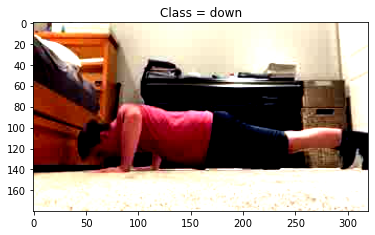

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


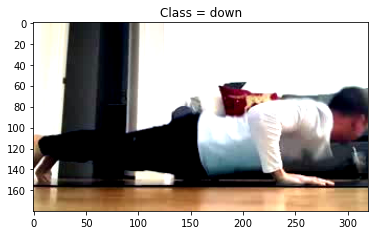

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


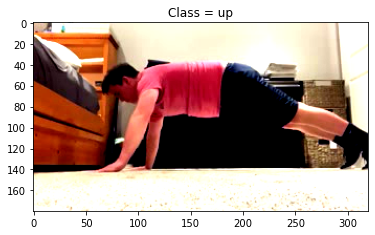

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


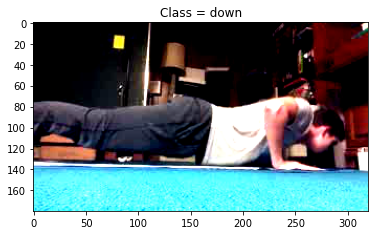

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


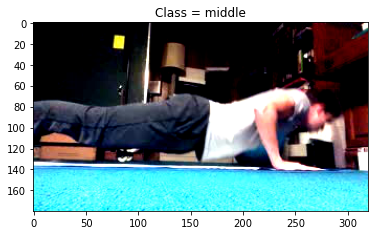

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


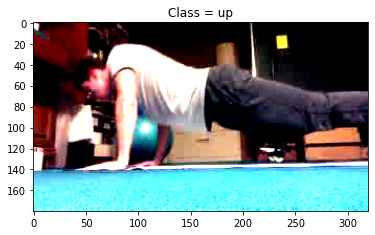

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


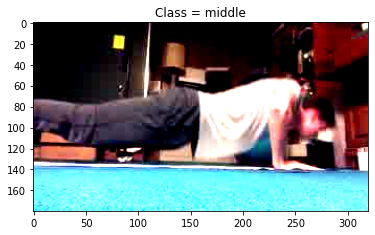

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


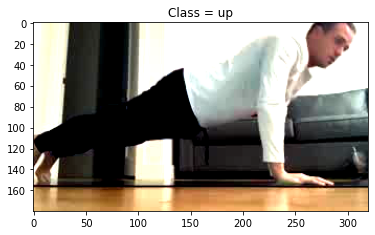

In [276]:
for i, data in enumerate(valloader):
    images, labels = data
    for i in range(len(labels)):
        show_sample(images[i], labels[i])
    break

In [172]:
for param in vgg16.parameters():
    param.requires_grad = True

In [174]:
epochs = 10
vgg16.cuda() # make sure we are on gpu
running_loss = 0
for j in range(epochs):
    for i, data in enumerate(trainloader):
        vgg16.train() # set it to training mode
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad() # zero out the gradients
        outputs = vgg16(inputs) # Forward Propogation
        loss = criterion(outputs, labels) # get loss from loss fn
        loss.backward() # back prop
        optimizer.step() # update weights

        running_loss += loss.item() # Update batch loss to later average
        if i % 5 == 4:    # print every 2000 mini-batches
            # Outpul validation loss
            print('[%d, %5d] Loss: %.3f' %
                (j + 1, i + 1, running_loss / 100))
            running_loss = 0
    # print('Accuracy at end of epoch %d: %.3f' % (
    #     epoch, get_accuracy(vgg16, dataloader)))

[1,     5] Loss: 0.024
[1,    10] Loss: 0.024
[2,     5] Loss: 0.042
[2,    10] Loss: 0.020
[3,     5] Loss: 0.030
[3,    10] Loss: 0.020
[4,     5] Loss: 0.034
[4,    10] Loss: 0.023
[5,     5] Loss: 0.029
[5,    10] Loss: 0.017
[6,     5] Loss: 0.021
[6,    10] Loss: 0.018
[7,     5] Loss: 0.023
[7,    10] Loss: 0.015
[8,     5] Loss: 0.021
[8,    10] Loss: 0.016
[9,     5] Loss: 0.023
[9,    10] Loss: 0.016
[10,     5] Loss: 0.025
[10,    10] Loss: 0.015


In [285]:
correct = 0
total = 0
vgg16.cuda()
with torch.no_grad():           # Do not update gradients when evaluating
    for data in valloader: 
        images, labels = data[0].to(device), data[1].to(device) #Put data on CUDA
        vgg16.eval() # Set model to eval mode
        outputs = vgg16(images) # Run forward prop
        _, predicted = torch.max(outputs.data, 1) # Get the arg max
        total += labels.size(0) # Add the mini batch size
        correct += (predicted == labels).sum().item() # add the correcrt predictions
print(100 * correct / total)

77.08333333333333


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


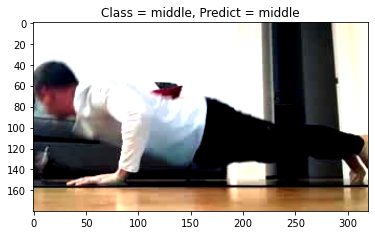

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


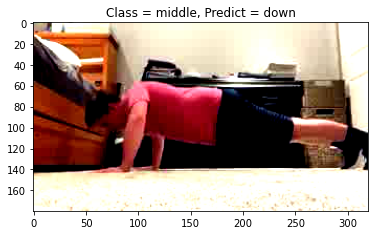

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


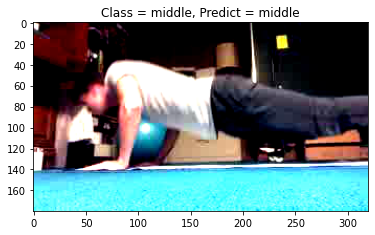

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


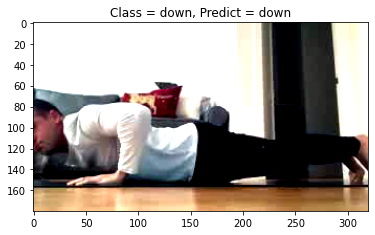

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


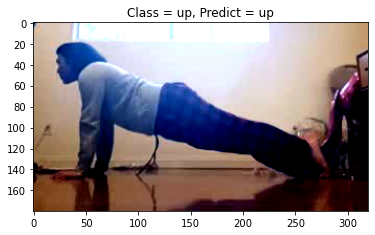

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


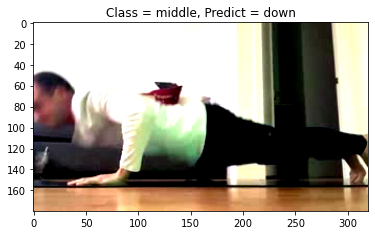

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


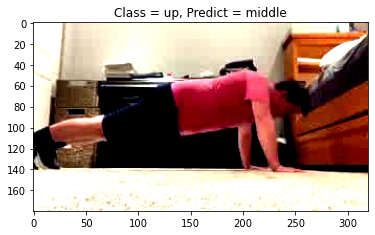

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


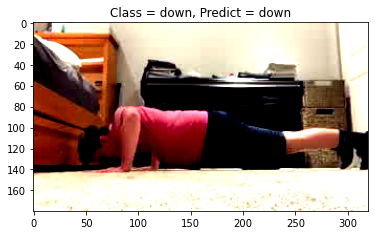

In [288]:
with torch.no_grad():           # Do not update gradients when evaluating
    for i, data in enumerate(valloader):
        images, labels = data[0].to(device), data[1].to(device)
        vgg16.eval() 
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1) # Get the arg max
        for i in range(len(labels)):
            show_sample(images[i], labels[i], predicted[i])
        break
